In [534]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.decomposition import PCA
import random

In [535]:
# initialization
subjects = 200
types = 2
usePCA = True
useMDA = False
dataset_file = 'Data/data.mat'
dataset = 'face'

In [536]:
# load the dataset
data = sio.loadmat(dataset_file)
data = data.get(dataset)

In [537]:
# flatten the dataset
flattened = np.zeros(shape=(subjects*types, data.shape[0]*data.shape[1]))

# label for neutral and expression - 0 / 1
y = np.ones(shape=(subjects*types)) # by default all are one
c = 0
for i in range(0, data.shape[2], 3):
    temp1 = data[:,:,i]
    temp2 = data[:,:,i+1]
    flattened[c] = temp1.flatten()
    flattened[c+1] = temp2.flatten()
    y[c+1] = -1 # expression label -1
    c += 2

In [538]:
def doPCA(flattened, dim):
    pca = PCA(dim)
    projected = pca.fit_transform(flattened)
    return projected

Minimum dimensions required for 95% retention  132


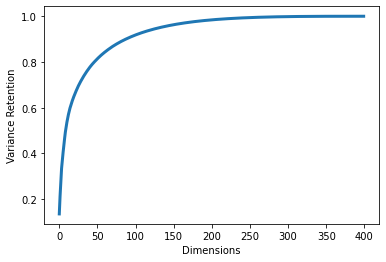

In [539]:
# Perform PCA if true
if usePCA:
    pca = PCA().fit(flattened)
    plt.figure()
    plt.xlabel('Dimensions')
    plt.ylabel('Variance Retention')
    plt.plot(pca.explained_variance_ratio_.cumsum(), lw=3)
    min_dim = (np.where(pca.explained_variance_ratio_.cumsum() > 0.95))[0][0]
    print('Minimum dimensions required for 95% retention ', min_dim)
    projected = doPCA(flattened, min_dim+10)

In [540]:
projected.shape

(400, 142)

In [541]:
testing_data.shape

(100, 1)

In [542]:
training_data.shape

(320, 1)

In [407]:
projected = flattened

In [543]:
# init the training and testing datad
training_size = 300 #int(4*projected.shape[0]/5)
testing_size = 100 #subjects*types - training_size
# training_data = np.zeros(shape=(training_size, projected.shape[1]))
# testing_data = np.zeros(shape=(testing_size, projected.shape[1]))

y_train = y[:training_size]
y_test = y[training_size:]

training_data = projected[:training_size]
testing_data = projected[training_size:]

print('training_data size = ', training_size)
print('testing_data size = ', testing_size)

training_data size =  300
testing_data size =  100


# ML ESTIMATE

In [544]:
expression_size = int(training_size / 2)
neutral_size = expression_size
expression = np.zeros(shape=(expression_size, projected.shape[1]))
neutral = np.zeros(shape=(neutral_size, projected.shape[1]))
# build up the expression and neutral training set
c = 0
for i in range(0, training_size, 2):
    neutral[c] = projected[i]
    expression[c] = projected[i+1]
    c += 1

### Calculate class mean and covariance

In [545]:
# mean
mu_expression = np.mean(expression, axis=0)
mu_neutral = np.mean(neutral, axis=0)

# covariance expression
mat = expression - mu_expression
cov_expression = (np.dot(mat.T, mat)) / expression_size

#covariance neutral
mat = neutral - mu_neutral
cov_neutral = (np.dot(mat.T, mat)) / neutral_size

In [546]:
# check for zero determinant, add noise if zero
while abs(np.linalg.det(cov_expression)) <= 2:
    cov_expression = cov_expression + 0.001*np.identity(cov_expression.shape[0])
print(np.linalg.det(cov_expression))

while abs(np.linalg.det(cov_neutral)) <= 2:
    cov_neutral = cov_neutral + 0.001*np.identity(cov_neutral.shape[0])
print(np.linalg.det(cov_neutral))

2.135214323188809
2.3081721575630496


# Test data using ML

In [547]:
score = 0
for i in range(testing_size):
    likelihood_neutral = -0.5*math.log(np.linalg.det(cov_neutral)) - 0.5*np.dot((testing_data[i] - mu_neutral), np.dot(np.linalg.inv(cov_neutral), (testing_data[i] - mu_neutral).T))
    likelihood_expression = -0.5*math.log(np.linalg.det(cov_expression)) - 0.5*np.dot((testing_data[i] - mu_expression), np.dot(np.linalg.inv(cov_expression), (testing_data[i] - mu_expression).T))
    if likelihood_neutral > likelihood_expression:
        predicted_class = 1
    else:
        predicted_class = -1
    if predicted_class == y_test[i]:
        score += 1
        # print('Correct classification, score = ', score)
    # else:
        # print('Incorrect classification for test data ', i)

accuracy = score*100/testing_size
print('Accuracy of ML Estimate = ',accuracy)

Accuracy of ML Estimate =  87.0


# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# K-NN Estimate

Accuracy of  1 -NN =  84.0
Accuracy of  2 -NN =  92.5
Accuracy of  3 -NN =  91.0
Accuracy of  4 -NN =  93.75
Accuracy of  5 -NN =  93.0
Accuracy of  6 -NN =  94.84536082474227
Accuracy of  7 -NN =  95.0
Accuracy of  8 -NN =  95.78947368421052
Accuracy of  9 -NN =  92.0


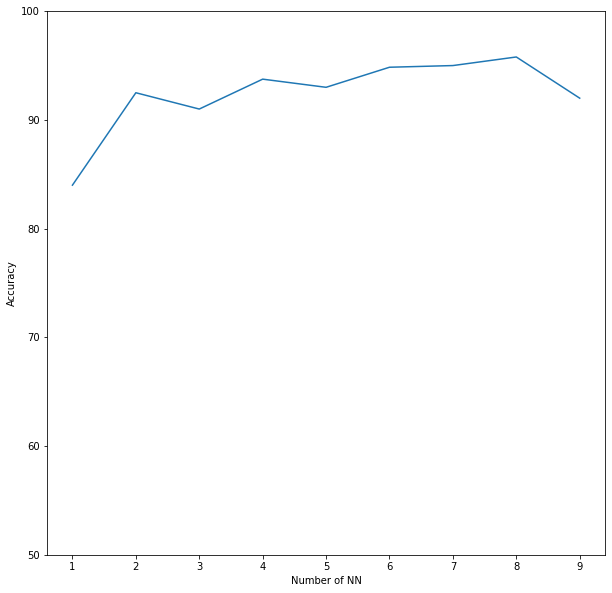

In [523]:
# K-NN
nn = [i for i in range(1,10)]
acc = []
for k in nn:
    score = 0
    actual_tests = len(testing_data)

    for i in range(1,len(testing_data)):
        neutral_score = 0
        expression_score = 0

        test_class = y_test[i]
        dist = np.zeros(shape=(len(training_data)))
        
        for j in range(len(training_data)):
            # d =  np.dot(testing_data[i] - mu[j], np.dot(np.linalg.inv(cov[j]), (testing_data[i] - mu[j]).T))
            d = np.linalg.norm(testing_data[i] - training_data[j])
            dist[j] = d
        
        sort = np.argsort(dist)
        
        predicted_nearest_class = np.zeros(shape=dist.shape[0])
        votes_class = np.zeros(shape=subjects)

        for l in range(k):
            predicted_nearest_class[l] = y_train[int(sort[l])]
            if predicted_nearest_class[l] == 1:
                neutral_score += 1
            else:
                expression_score += 1

        if neutral_score > expression_score:
            predicted_class = 1
        elif neutral_score < expression_score:
            predicted_class = -1
        elif neutral_score == expression_score:
            # print('Tie')
            actual_tests -= 1
            continue

        if predicted_class == test_class:
            score += 1
  
    accuracy = (score*100/actual_tests)
    print('Accuracy of ',str(k),'-NN = ', accuracy)
    acc.append(accuracy)

plt.figure(figsize=(10,10))
plt.ylim(50,100)
plt.xlabel('Number of NN')
plt.ylabel('Accuracy')
plt.plot(nn, acc)

In [ ]:
plt.figure(figsize=(10,10))
plt.ylim(50,100)
plt.xlabel('Number of NN')
plt.ylabel('Accuracy')
plt.plot(nn, acc)

In [522]:
#lda
# Accuracy of  1 -NN =  86.0
# Accuracy of  2 -NN =  94.04761904761905
# Accuracy of  3 -NN =  95.0
# Accuracy of  4 -NN =  94.89795918367346
# Accuracy of  5 -NN =  94.0
# Accuracy of  6 -NN =  94.79166666666667
# Accuracy of  7 -NN =  94.0
# Accuracy of  8 -NN =  94.79166666666667
# Accuracy of  9 -NN =  92.0

In [ ]:
#PCA
# Accuracy of  1 -NN =  78.0
# Accuracy of  2 -NN =  87.14285714285714
# Accuracy of  3 -NN =  78.0
# Accuracy of  4 -NN =  85.46511627906976
# Accuracy of  5 -NN =  81.5
# Accuracy of  6 -NN =  85.87570621468926
# Accuracy of  7 -NN =  80.5
# Accuracy of  8 -NN =  84.26966292134831
# Accuracy of  9 -NN =  80.5

# SVM

In [393]:
import cvxopt
import cvxopt.solvers

In [524]:
#Form the Kernel
def get_kernel(x, kernel_type, param=0.006):
    kernel = np.zeros(shape=(x.shape[0], x.shape[0]), dtype=float)
    for i in range(kernel.shape[0]):
        for j in range(kernel.shape[1]):
            if kernel_type == 'rbf':
                kernel[i][j] = math.exp( -1*(np.linalg.norm(x[i] - x[j])**2)/(param*param) )
            elif kernel_type == 'poly':
                kernel[i][j] = math.pow((np.dot(x[i].T, x[j]) +1), param)
            else:
                kernel[i][j] = np.dot(x[i].T, x[j])
    
    while abs(np.linalg.det(kernel)) <= 2:
        kernel = kernel + 0.001*np.identity(kernel.shape[0])
    print(np.linalg.det(kernel))
    
    return kernel

In [12]:
# P = cvxopt.matrix(np.outer(y_train,y_train)*kernel)
# q = cvxopt.matrix(np.ones(training_size) * -1)
# A = cvxopt.matrix(y_train, (1,training_size))
# b = cvxopt.matrix(0.0)
# G = cvxopt.matrix(np.diag(np.ones(training_size) * -1))
# h = cvxopt.matrix(np.zeros(training_size))

# solution = cvxopt.solvers.qp(P, q, G, h, A, b)

In [394]:
def evaluate_kernel(x, y, kernel_type='rbf', param=0.006):
    """Evaluates the kernel at a specific test data

    Args:
        x (np array): Training data
        y (np array): Test point
        kernel_type (str, optional): rbf or poly. Defaults to 'rbf'.
        param (int, optional): scale of the kernel. Defaults to 10.

    Returns:
        [float]: [kernel evaluated at y]
    """
    val = np.zeros(shape=(x.shape[0]), dtype=float)
    for i in range(x.shape[0]):
        if kernel_type == 'rbf':
            val[i] += math.exp( -1*(np.linalg.norm(x[i] - y)**2)/(param*param) )
        elif kernel_type == 'poly':
            val[i] += math.pow((np.dot(x[i].T, y) +1), param)
        else:
            val[i] = np.dot(x[i].T, y)
        
    return val

In [240]:
# tr = training_data
# te = testing_data
# ytr = y_train
# yte = y_test
# trs = training_size
# tes = testing_size

# training_data = tr
# testing_data = te
# y_train = ytr
# y_test = yte
# training_size = 300
# testing_size = 100

In [ ]:
# training_data = np.array([[1,1], [2,2], [2,0], [0,0], [1,0] , [0,1]])
# testing_data = np.array([[1.5,1.5], [1.75,1.75], [0.5,0.25], [0.5,0.5]])
# y_train = np.array([1,1,1,-1,-1,-1], dtype=float)
# y_test = np.array([1,1,-1,-1], dtype=float)
# training_size = 6
# testing_size = 4

In [548]:
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix

In [550]:
gam = [0.005]
for g in gam:
    clf = svm.SVC(kernel='rbf')
    clf.fit(training_data, y_train)
    pred = clf.predict(testing_data)
    print(accuracy_score(y_test, pred))

0.87


In [551]:
clf.intercept_

array([-0.11742175])

In [552]:
1/(training_size*training_data.var())

0.006773038322295767

In [462]:
clf.gamma

'scale'

In [ ]:
pred = clf.predict(testing_data)
pred

In [17]:
from sklearn.metrics import accuracy_score
# accuracy_score(y_test, pred)

In [449]:
kernel = get_kernel(training_data, kernel_type=kernel_type, param=0.0009118136546038253)

In [450]:
# while abs(np.linalg.det(kernel)) <= 2:
#     kernel = kernel + 0.001*np.identity(kernel.shape[0])
# print(np.linalg.det(kernel))

2.671444945969816


In [557]:
params = [1,2,3,4,5,6,7,8,9,10]
# params = [6,6.1,6.2,6.3,6.4,6.5,6.6,6.7,6.8,6.9,7]
# params = [0.00091, 0.002, 0.003, 0.008, 0.2, 0.3, 0.0002, 1,2,3,4,5]
# params = [3]
# params = [0.006773038322295767]
# params = [2.1,2.2,2.3,2.4,2.5,2.6,2.7,2.8,2.9]
# params = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,2,3,4,5,6]
scores = []
# param = 1
for param in params:
    # C = 0.5
    threshold = 1e-5
    kernel_type = 'rbf'
    kernel = get_kernel(training_data, kernel_type=kernel_type, param=param)

    P = cvxopt.matrix(np.outer(y_train,y_train)*kernel)
    q = cvxopt.matrix(np.ones(training_size) * -1)
    A = cvxopt.matrix(y_train, (1,training_size))
    b = cvxopt.matrix(0.0)
    G = cvxopt.matrix(np.diag(np.ones(training_size) * -1))
    # G = cvxopt.matrix(np.vstack((np.eye(training_size)*-1,np.eye(training_size))))
    h = cvxopt.matrix(np.zeros(training_size))
    # h = cvxopt.matrix(np.hstack((np.zeros(training_size), np.ones(training_size) * C)))

    solution = cvxopt.solvers.qp(P, q, G, h, A, b)

    # support vectors
    sv = np.ravel(solution['x'])

    for i in range(sv.shape[0]):
        if sv[i] <= threshold:
            sv[i] = 0

    # hyperplane
    # theta = np.dot((sv*y_train).T, training_data)

    # Find the intercept
    idx = np.argsort(sv)
    idx = idx[::-1][0]

    k1 = evaluate_kernel(training_data, training_data[idx], kernel_type=kernel_type, param=param)
    sum = 0.0
    for m in range(training_size):
        sum += k1[m]*sv[m]*y_train[m]
    theta0 = 1/y_train[idx] - sum

    # cross-validation
    score = 0
    for i in range(len(testing_data)):
        # test = np.dot((sv*y_train).T, evaluate_kernel(training_data, testing_data[i], kernel_type, param)) + theta0
        # test = np.dot(theta.T, testing_data[i]) + theta0

        k2 = evaluate_kernel(training_data, testing_data[i], kernel_type=kernel_type, param=param)
        test = 0.0

        for m in range(training_size):
            test += k2[m]*y_train[m]*sv[m]

        test += theta0

        if (test*y_test[i] >= 0):
            score += 1
            # print('Correct')
        # else:
            # print('Incorrect')

    print(score)
    accuracy = (score/testing_size)*100
    scores.append(accuracy)
    print('Cross Validation Accuracy with ', kernel_type, ' kernel with param ', str(param), ' is = ', str(accuracy))

# label = kernel_type + ' Kernel Parameter'
# label = 'Poly Kernel with Slack'
# plt.xlabel(label)
# plt.ylabel('Accuracy')
# plt.plot(np.array(params), np.array(scores))
    

2.456291330358944
     pcost       dcost       gap    pres   dres
 0: -1.1228e+02 -2.6206e+02  1e+02  2e-14  1e+00
 1: -1.4119e+02 -1.4348e+02  2e+00  6e-15  2e-01
 2: -1.4955e+02 -1.4982e+02  3e-01  3e-15  1e-16
 3: -1.4955e+02 -1.4955e+02  3e-03  3e-15  1e-16
 4: -1.4955e+02 -1.4955e+02  3e-05  5e-15  1e-16
Optimal solution found.
50
Cross Validation Accuracy with  rbf  kernel with param  1  is =  50.0
2.403095044255576
     pcost       dcost       gap    pres   dres
 0: -1.1245e+02 -2.6743e+02  2e+02  6e-15  2e+00
 1: -1.4080e+02 -1.4714e+02  6e+00  7e-15  3e-01
 2: -1.4991e+02 -1.5062e+02  7e-01  1e-14  2e-16
 3: -1.4991e+02 -1.4991e+02  7e-03  3e-15  2e-16
 4: -1.4991e+02 -1.4991e+02  7e-05  3e-15  1e-16
Optimal solution found.
50
Cross Validation Accuracy with  rbf  kernel with param  2  is =  50.0
2.2221035872150527
     pcost       dcost       gap    pres   dres
 0: -1.1161e+02 -2.8064e+02  2e+02  3e-15  2e+00
 1: -1.3765e+02 -1.5740e+02  2e+01  1e-14  4e-01
 2: -1.4865e+02 -1.

# ADA Boost

In [475]:
def get_support_vector_multipler(kernel, training_data, training_size, y_train, threshold = 1e-6, C=1):

    P = cvxopt.matrix(np.outer(y_train,y_train)*kernel)
    q = cvxopt.matrix(np.ones(training_size) * -1)
    A = cvxopt.matrix(y_train, (1,training_size))
    b = cvxopt.matrix(0.0)
    G = cvxopt.matrix(np.diag(np.ones(training_size) * -1))
    # G = cvxopt.matrix(np.vstack((np.eye(training_size)*-1,np.eye(training_size))))
    h = cvxopt.matrix(np.zeros(training_size))
    # h = cvxopt.matrix(np.hstack((np.zeros(training_size), np.ones(training_size) * C)))

    solution = cvxopt.solvers.qp(P, q, G, h, A, b)

    # support vectors
    sv = np.ravel(solution['x'])

    for i in range(sv.shape[0]):
        if sv[i] <= threshold:
            sv[i] = 0
    
    return sv


In [476]:
def get_test_train_validation(subjects, types, projected, training_size, testing_size):
    # init the training and testing data

    validation_size = subjects*types - testing_size 

    y_train = y[:training_size]
    y_validation = y[:validation_size]
    y_test = y[training_size:]

    training_data = projected[:training_size]
    validation_data = projected[:validation_size]
    testing_data = projected[validation_size:]

    print('training_data size = ', training_size)
    print('Validation size = ', validation_size)
    print('testing_data size = ', testing_size)

    return training_data, validation_data, testing_data, y_train, y_validation, y_test

In [533]:
from tqdm import tqdm
iterations = 5
training_size = 300
testing_size = 100

# weight vector
w = np.zeros(shape=(iterations, training_size))
P = np.zeros(shape=(iterations, training_size))
a = np.zeros(shape=(iterations))
test = np.zeros(shape=training_size)
w[0] = 1/training_size*np.ones(training_size)
theta0 = np.zeros(shape=(iterations))
theta = np.zeros(shape=(iterations, training_data.shape[1])) 

for k in range(iterations-1):

    threshold = 1e-5
    kernel_type = 'linear'

    # calculate P for each sample
    for i in range(training_size-1):
        P[k][i] = w[k][i] / (np.sum(w[k]))

    # training size for weak classifier
    training_size_weak = 100
    # testing size
    testing_size = 100
    error = 0.0

    while(True):

        ei = np.zeros(shape=(training_size))

        training_size_weak += 20
        # get the test, train, validation data
        training_data, validation_data, testing_data, y_train, y_validation, y_test = get_test_train_validation(subjects, types, projected, training_size_weak, testing_size)

        kernel = get_kernel(training_data, kernel_type=kernel_type)

        # find the multiplers
        sv = get_support_vector_multipler(kernel, training_data, training_size_weak, y_train)

        # hyperplane
        theta[k] = np.dot((sv*y_train).T, training_data)

        # Find the intercept
        idx = np.argsort(sv)
        idx = idx[::-1][0]

        theta0[k] = 1/y_train[idx] - np.dot(theta[k].T, training_data[idx])

        # cross-validation
        error = 0.0
        for i in range(len(validation_data)):
            test[i] = np.dot(theta[k].T, validation_data[i]) + theta0[k]

            if (test[i]*y_validation[i] < 0):
                error += P[k][i]
        
        print('Error in iteration ', str(k+1), ' is = ', str(error))

        if error < 0.6:
            break
    
    # update the coefficient
    if error != 0:
        a[k] = 0.5*math.log((1-error)/error)

    # update next weights

    for i in range(training_size):
        w[k+1][i] = w[k][i] * math.exp( (-1*y_validation[i]*test[i]) )
    
    

training_data size =  120
Validation size =  300
testing_data size =  100
2.10823972084102
     pcost       dcost       gap    pres   dres
 0: -2.1963e+01 -5.9396e+01  3e+02  2e+01  2e+00
 1: -2.5906e+01 -5.5023e+01  8e+01  4e+00  4e-01
 2: -1.8973e+01 -2.8821e+01  1e+01  1e-01  1e-02
 3: -2.0060e+01 -2.1177e+01  1e+00  7e-03  8e-04
 4: -2.0407e+01 -2.0514e+01  1e-01  4e-04  4e-05
 5: -2.0462e+01 -2.0470e+01  8e-03  1e-05  1e-06
 6: -2.0467e+01 -2.0468e+01  3e-04  2e-07  2e-08
 7: -2.0468e+01 -2.0468e+01  1e-05  2e-09  2e-10
Optimal solution found.
Error in iteration  1  is =  0.31666666666666676
training_data size =  120
Validation size =  300
testing_data size =  100
2.10823972084102
     pcost       dcost       gap    pres   dres
 0: -2.1963e+01 -5.9396e+01  3e+02  2e+01  2e+00
 1: -2.5906e+01 -5.5023e+01  8e+01  4e+00  4e-01
 2: -1.8973e+01 -2.8821e+01  1e+01  1e-01  1e-02
 3: -2.0060e+01 -2.1177e+01  1e+00  7e-03  8e-04
 4: -2.0407e+01 -2.0514e+01  1e-01  4e-04  4e-05
 5: -2.0462e

KeyboardInterrupt: 

In [233]:
score = 0
for i in range(len(validation_data)):
    test = 0
    for k in range(iterations):
        test += a[k] * np.dot(theta[k].T, validation_data[i]) + theta0[k]
    if (test*y_validation[i] > 0):
        score += 1

In [234]:
score

274

In [243]:
score = 0
for i in range(len(testing_data)):
    test = 0
    for k in range(iterations):
        test += a[k] * np.dot(theta[k].T, testing_data[i]) + theta0[k]
    if (test*y_test[i] > 0):
        score += 1

In [244]:
score

84

# Check LDA

In [484]:
neutral = np.zeros(shape=(subjects, flattened.shape[1]))
expression = np.zeros(shape=(subjects, flattened.shape[1]))

c = 0
for i in range(0, subjects*types, 2):
    neutral[c] = flattened[i]
    expression[c] = flattened[i+1]
    c+=1
mu_neutral = np.mean(neutral, axis=0)
mu_expression = np.mean(expression, axis=0)

mat = neutral - mu_neutral
cov_neutral = np.dot(mat.T, mat) / subjects
mat = expression - mu_neutral
cov_expression = np.dot(mat.T, mat) / subjects
mat = (mu_neutral - mu_expression).reshape((1, flattened.shape[1]))
sigma_b = np.dot(mat.T, mat)
sigma_w = cov_neutral + cov_neutral

In [485]:
# while abs(np.linalg.det(sigma_b)) <= 2:
sigma_b = sigma_b + 0.999*np.identity(sigma_b.shape[0])
print(np.linalg.det(sigma_b))

# while abs(np.linalg.det(sigma_w)) <= 2:
sigma_w = sigma_w + 0.868*np.identity(sigma_w.shape[0])
print(np.linalg.det(sigma_w))

6.937939257947475
5.39901519806892


In [491]:
a = np.dot(np.linalg.inv(sigma_w), sigma_b)

In [487]:
val, vec = np.linalg.eig(a)

In [433]:
idx = val.argsort()[::-1]
vec_  = vec[:, idx]
vec_.shape
dim = 1
vec__ = vec_[:,:dim]
vec__.shape
f = np.dot(flattened, vec__)

In [434]:
f.shape

(400, 1)

In [515]:
# projected_bcp = projected
projected  = f

In [493]:
mu_neutral.shape

(504,)

In [494]:
check = np.dot(np.linalg.inv(sigma_w), (mu_neutral - mu_expression))

In [509]:
check = check.reshape((check.shape[0],1))

In [498]:
vec__.shape

(504, 1)

In [510]:
f = np.dot(flattened, check)

In [511]:
f.shape

(400, 1)

In [512]:
flattened.shape

(400, 504)